In [247]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [264]:
df = pd.read_csv('daily covid - owid.csv', parse_dates=['date'])

df = df.sort_values('date')

df.set_index('date', inplace=True)
df.index = pd.DatetimeIndex(df.index, freq='D')


print(df.isnull().sum()) #0
print(df.describe())

df['cases'] = np.log(df['cases'].replace(0, 1))  

df['cases'] = df['cases'].apply(lambda x: np.nan if x > 20 else x) 
df = df.ffill()  

split_index = int(len(df) * 0.85)
split_index2 = int(len(df) * 0.3)
train = df.loc['2020-01-01':'2023-09-25']
test = df.loc['2023-09-26':'2024-05-25']

cases    0
dtype: int64
              cases
count  1.606000e+03
mean   2.046565e+06
std    9.400260e+06
min    0.000000e+00
25%    0.000000e+00
50%    0.000000e+00
75%    0.000000e+00
max    1.777728e+08


In [265]:
model = ExponentialSmoothing(
    train['cases'], 
    trend='add', 
    seasonal='add', 
    seasonal_periods=7,  # Weekly seasonality
    initialization_method="estimated"
).fit(optimized=True, minimize_kwargs={'options': {'maxiter': 1000}})

predictions = model.forecast(len(test))

predictions = np.exp(predictions)

test.loc[:, 'cases'] = np.exp(test['cases'].clip(upper=20)) 

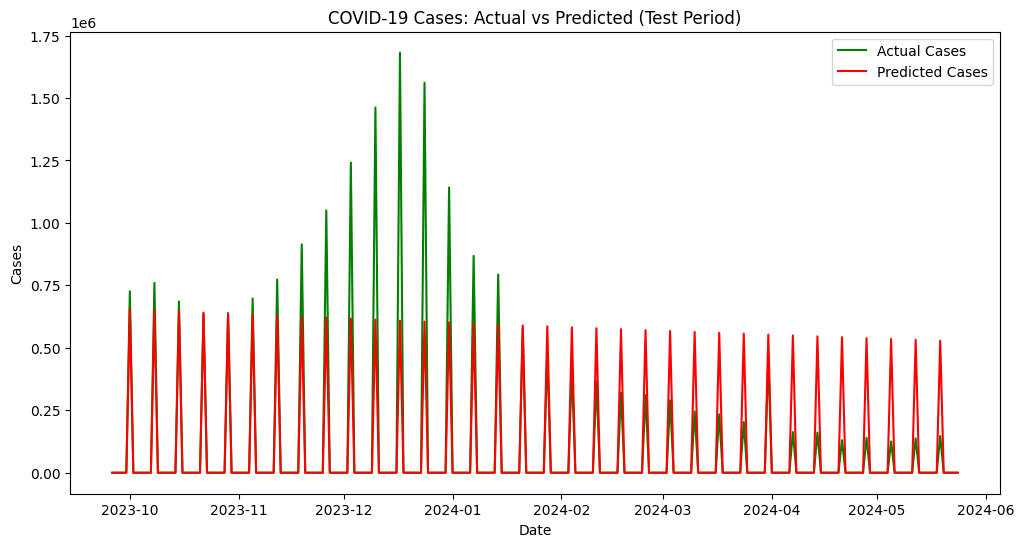

In [266]:
# Plot the actual vs predicted values for the predicted period
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['cases'], label='Actual Cases', color='green')
plt.plot(test.index, predictions, label='Predicted Cases', color='red')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.title('COVID-19 Cases: Actual vs Predicted (Test Period)')
plt.legend()
plt.show()

In [267]:
mae = mean_absolute_error(test['cases'], predictions)
mse = mean_squared_error(test['cases'], predictions)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(test['cases'], predictions)
accuracy = 100 - mape * 100


print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")
print(f"Accuracy: {accuracy}%")

MAE: 44726.17498955003
MSE: 23251481435.64769
RMSE: 152484.36456124834
MAPE: 0.22468011911367983
Accuracy: 77.53198808863202%
